In [1]:
%matplotlib notebook
%pylab
import matplotlib.pyplot as plt
import pysynphot as S
import astropy
import astropy.constants
import astropy.coordinates as c
import astropy.units as u
import astropy.table as at
import h5py
import bisect
from collections import OrderedDict

from matplotlib import rc
rc('text', usetex=True)
rc('axes', unicode_minus=True)
rc('font',**{'family':'serif','serif':['Times New Roman']})

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [9]:

bands = [('G230LB', 'stis,g230lb'),
        ('F275W', 'wfc3,uvis2,f275w'),
        ('F336W','wfc3,uvis2,f336w'),
        ('F475W','wfc3,uvis2,f475w'),
        ('F606W','wfc3,uvis2,f606w'),
        ('F814W','wfc3,uvis2,f814w'),
        ('F110W','wfc3,ir,f110w'),
        ('F160W','wfc3,ir,f160w'),
        ('G102','wfc3,ir,g102'),
        ('G141','wfc3,ir,g141')]
bands = OrderedDict(bands)

colors = '4,6,0,9,2,3,8,1,5,7'
colors = dict(zip(bands.keys(), colors.split(',')))
print(colors)

{'G230LB': '4', 'F275W': '6', 'F336W': '0', 'F475W': '9', 'F606W': '2', 'F814W': '3', 'F110W': '8', 'F160W': '1', 'G102': '5', 'G141': '7'}


In [3]:
atmos = at.Table.read('atmos_12_lowater_aerosol.dat', format='ascii', names=['wave','atm'])
atmos['wave']*=10.
atmos_ir1 = at.Table.read('cptrans_zm_43_10.dat', format='ascii', names=['wave','atm'])
atmos_ir1['wave']*= 10000
atmos_ir2 = at.Table.read('cptrans_zm_43_15.dat', format='ascii', names=['wave','atm'])
atmos_ir2['wave']*= 10000

In [4]:
atmos_ir = atmos_ir1.copy()
atmos_ir['atm'] = (atmos_ir1['atm'] + atmos_ir2['atm'])*0.5

ind = atmos['wave'] >= atmos_ir['wave'].min()
ind2 = atmos_ir['wave'] <= atmos['wave'][ind].max()
interp_atm = np.interp(atmos_ir['wave'][ind2], atmos['wave'][ind] , atmos['atm'][ind])
atmos['atm'] *= np.median(atmos_ir['atm'][ind2]/interp_atm)

/Users/gnarayan/anaconda3/envs/WDmodel/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


In [5]:


# define some constants
SPEED_OF_LIGHT = astropy.constants.c.cgs.value
TELESCOPE_AREA = 25.0 * 10000 # cm^2 -- Area of the telescope has to be in centimeters because pysynphot...
S.setref(area=TELESCOPE_AREA)
SEC_TO_DAY = u.second.to(u.day)
CM_TO_ANGSTROM = u.centimeter.to(u.angstrom)
ANGSTROM_TO_CM = u.angstrom.to(u.centimeter)
FNU_TO_MJY = (u.erg/(u.centimeter**2)/u.second/u.Hertz).to(u.microjansky)
ANGSTROM_TO_MICRON = u.angstrom.to(u.micron)
MPC_TO_CM = u.megaparsec.to(u.centimeter)
DISTANCE = [40, 80, 120, 200]
TMAX = 90

class Kilonova(object):
    def __init__(self):
        """
        Read Dan's Kilonova spectral model and return the base arrays
        """
        name1 = 'knova_d1_n10_m0.035_vk0.20_Xlan1e-2.0.h5'
        fin1    = h5py.File(name1,'r')

        name2 = 'knova_d1_n50_m0.025_vk0.25_fd0.3_Xlan1e-6.0_vs0.32_ns12.0.h5'
        fin2    = h5py.File(name2,'r')

        # frequency in Hz
        nu    = np.array(fin1['nu'],dtype='d')
        # array of time in seconds
        times = np.array(fin1['time'])
        # covert time to days
        times *= SEC_TO_DAY

        # frequency in Hz
        nu2    = np.array(fin2['nu'],dtype='d')
        # array of time in seconds
        times2 = np.array(fin2['time'])
        # covert time to days
        times2 *= SEC_TO_DAY

        # specific luminosity (ergs/s/Hz)
        # this is a 2D array, Lnu[times][nu]
        Lnu_all1   = np.array(fin1['Lnu'],dtype='d')
        Lnu_all2   = np.array(fin2['Lnu'],dtype='d')

        Lnu_all = np.zeros((len(times),len(nu)))
        for i in np.arange(0,len(times)-1):
            for j in np.arange(0,len(nu)-1):
                it1 = bisect.bisect(times2,times[i])
                it2 = bisect.bisect(nu2,nu[j])
                Lnu_all[i,j] = Lnu_all1[i,j]+Lnu_all2[it1,it2]

        self._times   = times
        self._nu      = nu
        self._Lnu_all = Lnu_all

    def get_model(self, phase):
        """
        Get the flam spectrum for some specific phase
        """
        it  = bisect.bisect(self._times, phase)
        it -= 1 # I think Dan's array indexing is off by 1
        Lnu = self._Lnu_all[it,:]
        # if you want thing in Flambda (ergs/s/Angstrom)
        lam  = SPEED_OF_LIGHT/self._nu*CM_TO_ANGSTROM
        Llam = Lnu*self._nu**2.0/SPEED_OF_LIGHT/CM_TO_ANGSTROM
        return lam, Llam

    def get_norm_model(self, phase, distance):
        """
        Get the flam spectrum for some specific phase and distance
        """
        dist = c.Distance(distance*u.megaparsec)
        z = dist.z
        lam, flam = self.get_model(phase)
        lamz = lam*(1.+z)
        fnorm = flam/(4*np.pi*(distance*MPC_TO_CM)**2.)
        return lamz, fnorm

In [10]:
kn = Kilonova()
l1, f1 = kn.get_norm_model(1, 80)
l3, f3 = kn.get_norm_model(3, 80)
l12, f12 = kn.get_norm_model(5, 80)

<IPython.core.display.Javascript object>


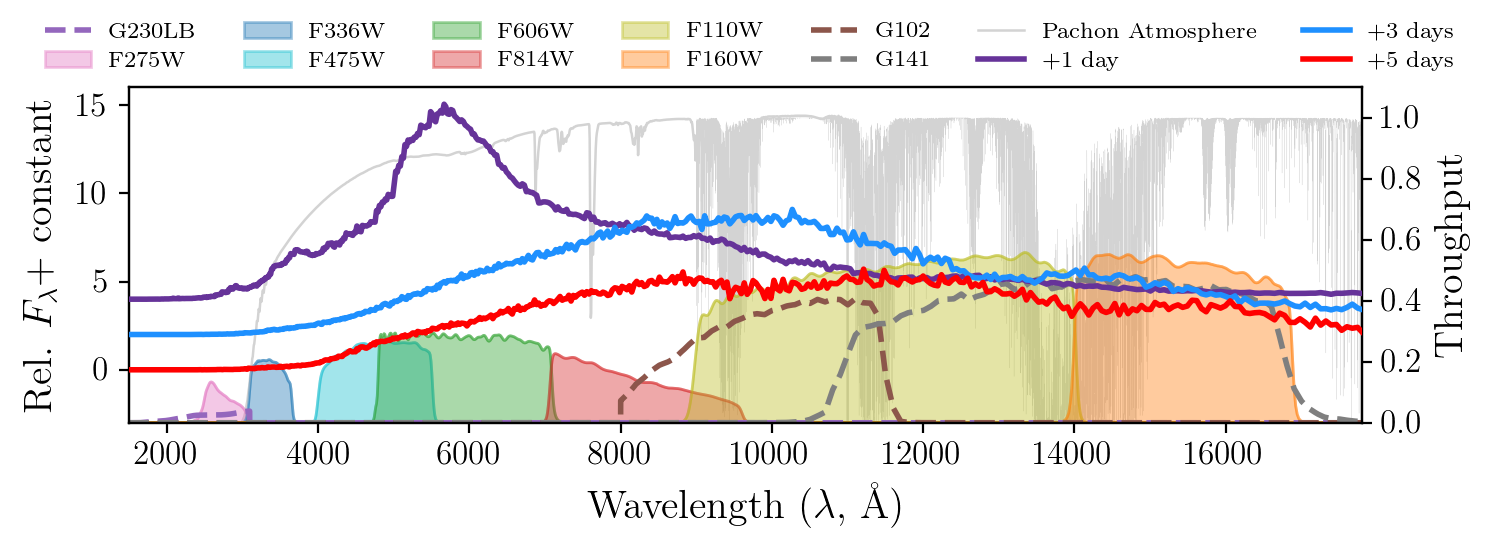

In [62]:
fig = plt.figure(figsize=(7.5, 0.8*3.5))
lines = []
ax2 = fig.add_subplot(111)
ax = ax2.twinx()

for i, pb in enumerate(bands.keys()):
    obsmode = bands[pb]
    filt = S.ObsBandpass(obsmode)

    wave = filt.wave
    resp = filt.throughput

    color = 'C{}'.format(colors[pb])
    if pb.startswith('G'):
        ls='--'
        zorder=1
    else:
        ls='-'
        zorder=-1
    
    
    if not pb.startswith('G'):
        ax.plot(wave, resp, color=color, lw=1, marker='None', ls=ls, zorder=zorder, alpha=0.45)
        pt = ax.fill_between(wave, resp, 0, color=color, alpha=0.4)
        lines.append(pt)
    else:
        ln = ax.plot(wave, resp, color=color, lw=2, marker='None', ls=ls, zorder=zorder)
        lines.append(ln[0])

ln = ax.plot(atmos['wave'], atmos['atm'], color='lightgrey', ls='-', lw=0.9, zorder=-1)
lines.append(ln[0])
ax.plot(atmos_ir['wave'], atmos_ir['atm'], color='lightgrey', ls='-', lw=0.1, zorder=-10)


ax.set_xlim(1500, 17800)
ax.set_ylim(0, 1.1)
yticks = np.arange(0, 1.1, 0.2)
ax.set_yticks(yticks)
ax.set_ylabel('Throughput', fontsize='x-large')

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")

ln1 = ax2.plot(l1, f1/f1.mean()+5-1, color='rebeccapurple', lw=2, linestyle='-', zorder=10)
ln3 = ax2.plot(l3, f3/f3.mean()+5-3, color='dodgerblue', lw=2, linestyle='-', zorder=10)
ln12 = ax2.plot(l12, f12/f12.mean(), color='red', lw=2, linestyle='-', zorder=10)
lines.append(ln1[0])
lines.append(ln3[0])
lines.append(ln12[0])
ax2.set_ylabel('Rel. $F_{\lambda} + $ constant', fontsize='x-large')
ax2.set_xlabel(r'Wavelength ($\lambda$, \AA)', fontsize='x-large')

#large tick labels
ax2.tick_params(axis='both', which='major', labelsize='large')
ax.tick_params(axis='both', which='major', labelsize='large')

# zorder trickery
ax2.set_zorder(ax.get_zorder()+1) # put ax in front of ax2
ax2.patch.set_visible(False) # hide the 'canvas' 
ax2.set_ylim(-3, 16)


fig.legend(lines, list(bands.keys())+['Pachon Atmosphere','+1 day', '+3 days', '+5 days'], 'upper center',\
           ncol=7, frameon=False, fontsize='small', labelspacing=0.3)
fig.tight_layout(rect=[0.,0,1,0.91])

In [63]:
fig.savefig('kn_hst_bands.pdf')

In [49]:
f275w = S.ObsBandpass(bands['F275W'])
f336w = S.ObsBandpass(bands['F336W'])

In [50]:
l, f = kn.get_norm_model(1, 80)

In [51]:
q = S.ArraySpectrum(l, f, fluxunits='flam')

In [52]:
o1 = S.Observation(q, f275w)
o2 = S.Observation(q, f336w)

In [53]:
o1.effstim('abmag')
o2.effstim('abmag')

21.58247455698433